<a href="https://colab.research.google.com/github/arcra-inc/ai-kaigisitu/blob/main/%E4%B8%B8%E6%A5%BD%E7%B4%99%E5%88%A4%E5%AE%9A_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 環境設定・初期化


In [1]:
!ls /content/drive/MyDrive

 20250217_大和心御中_業務委託契約書.gdoc
 20250422_ダイキン工業株式会社御中_ARCRA.gdoc
 240621_九州機電株式会社御中_フィードバックシート.gsheet
'241011_imagica御中 (1).gslides'
 241011_imagica御中.gslides
 250317_イマジカグループ御中.pptx
 250410_株式会社でんそく御中_ご契約書.gdoc
 250425_DAIKIN_システム分析お見積もり.gsheet
 250613_那須建設-電子黒板提案.gslides
'4月12日おにぎりパーティ 参加フォーム.gform'
'ARCRA 使い方ガイド.pptx'
'Colab Notebooks'
'Google Admin Downloads'
 Prefab様_ご共有資料.gdoc
 おにぎり4月.gsheet
 ガントチャート.gsheet
 ロトwebサイト-フィードバック管理表.gsheet
 ロトキャリア決済システム-考察.gsheet
 ロトテストケース.gsheet
 九州機電御中_AWS設定.gslides
 人材採用.gsheet
 工程表要件定義.gsheet
 建築業界が目指す状態.pptx
 提案内容目次.gslides
 株式会社ARCRA_事前アンケート.gform
 株式会社ARCRA_事前アンケート（回答）.gsheet
 決済システム-会員登録パターン.gsheet
 無題のスプレッドシート.gsheet
 無題のドキュメント.gdoc
 見積もり
 超AIロト神分析_日割り計算.gsheet


In [2]:
# === Google Drive マウント ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
# === ライブラリインポート ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, Subset, Dataset
from tqdm.auto import tqdm  # 進捗バー（I/O負荷を抑える設定で後述）
from torchvision import transforms, models
from PIL import Image
from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['DejaVu Sans', 'Hiragino Sans', 'Yu Gothic', 'Meiryo', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
import time
import json
import random
import math

# GPU使用設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

# 画像サイズが固定（224）なら cuDNN のアルゴリズム探索を有効化
torch.backends.cudnn.benchmark = True
# PyTorch 2.x: matmul の最適化（A100/T4 などで効くことが多い）
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")

使用デバイス: cuda


In [93]:
# === パス設定・パラメータ定義 ===
class Config:
    # === パス設定 ===
    # PARENT_DIR = Path('/content/drive/MyDrive/紙のスキャンデータ')  # 個人Drive
    PARENT_DIR = Path('/content/drive/Shareddrives/ARCRA/02_開発/丸楽紙業/共有資料/紙のスキャンデータ')  # 共有Drive
    DATASET_DIR = Path('/content/paper_dataset')  # 作業用ディレクトリ

    # === インデックス保存先設定 ===
    # 共有ドライブに保存（チーム全体でアクセス可能）
    INDEX_SAVE_DIR = Path('/content/drive/Shareddrives/ARCRA/02_開発/丸楽紙業/共有資料/インデックスファイル')
    # 個人ドライブに保存する場合は以下をコメントアウト
    # INDEX_SAVE_DIR = Path('/content/drive/MyDrive/paper_classification_indices')

    # === データ分割 ===
    TRAIN_CHILDREN = ['1500', 'IV']   # 学習用フォルダ
    TEST_CHILDREN = ['7700']          # テスト用フォルダ

    # === パッチ設定 ===
    PATCH_SIZE = 224
    TRAIN_STRIDE = 224
    TEST_STRIDE = 224  # テスト時はより粗く

    # === 学習設定 ===
    BATCH_SIZE = 128
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 3

    # === その他 ===
    IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}
    TRAIN_SUBSET_SIZE = 4400  # 学習データサブセット数

    # === 学習高速化オプション ===
    # 1エポックで使う学習サンプル数（パッチ）上限。大規模なら 50_000 ～ 200_000 で検討
    TRAIN_SAMPLES_PER_EPOCH = 12_000   # 例
    # 検証で使うサンプル数（上限）。早回し用に 10k〜30k など
    VAL_MAX_SAMPLES = 20_000            # 例

    # DataLoader 最適化
    NUM_WORKERS = 2          # Colab Pro なら 4〜8 で様子見
    PREFETCH_FACTOR = 4
    PIN_MEMORY = True
    PERSISTENT_WORKERS = True

    # AMP / compile / channels-last
    USE_AMP = False
    USE_TORCH_COMPILE = False
    USE_CHANNELS_LAST = False

    # === 乱数シード ===
    RANDOM_SEED = 42

# 設定を適用
config = Config()
config.DATASET_DIR.mkdir(parents=True, exist_ok=True)
config.INDEX_SAVE_DIR.mkdir(parents=True, exist_ok=True)  # インデックス保存ディレクトリ作成

print("=== パス確認 ===")
print(f"PARENT_DIR: {config.PARENT_DIR.resolve()}")
print(f"存在確認: {config.PARENT_DIR.exists()}")
print(f"INDEX_SAVE_DIR: {config.INDEX_SAVE_DIR.resolve()}")
print(f"インデックス保存先存在確認: {config.INDEX_SAVE_DIR.exists()}")

# 乱数シード固定
random.seed(config.RANDOM_SEED)
torch.manual_seed(config.RANDOM_SEED)

=== パス確認 ===
PARENT_DIR: /content/drive/Shareddrives/ARCRA/02_開発/丸楽紙業/共有資料/紙のスキャンデータ
存在確認: True
INDEX_SAVE_DIR: /content/drive/Shareddrives/ARCRA/02_開発/丸楽紙業/共有資料/インデックスファイル
インデックス保存先存在確認: True


# 2. データ準備

In [69]:
# === データ収集関数 ===
def gather_samples(parent_dir, child_names, img_exts):
    """
    指定された子フォルダから画像ファイルとクラス情報を収集

    Args:
        parent_dir (Path): 親ディレクトリ
        child_names (list): 子フォルダ名のリスト
        img_exts (set): 対象画像拡張子

    Returns:
        tuple: (samples, class_names)
            - samples: [(path, class_name), ...] のリスト
            - class_names: クラス名のセット
    """
    samples = []
    class_names = set()

    for name in child_names:
        child = parent_dir / name
        if not child.exists():
            raise FileNotFoundError(f'子フォルダが見つかりません: {child}')

        print(f"📁 処理中: {child.name}")

        # クラスディレクトリを走査
        for cls_dir in sorted([p for p in child.iterdir() if p.is_dir()]):
            class_name = cls_dir.name
            class_names.add(class_name)

            # 画像ファイルを収集
            img_count = 0
            for p in cls_dir.rglob('*'):
                if p.is_file() and p.suffix.lower() in img_exts:
                    samples.append((p, class_name))
                    img_count += 1

            print(f"  📄 {class_name}: {img_count}枚")

    return samples, sorted(class_names)

In [70]:
# === データ収集実行 ===
print("=== 学習データ収集 ===")
train_samples, train_classes = gather_samples(
    config.PARENT_DIR,
    config.TRAIN_CHILDREN,
    config.IMG_EXTS
)

print("\n=== テストデータ収集 ===")
test_samples, test_classes = gather_samples(
    config.PARENT_DIR,
    config.TEST_CHILDREN,
    config.IMG_EXTS
)

=== 学習データ収集 ===
📁 処理中: 1500
  📄 A-4　色上質: 464枚
  📄 B2　ふじ　しこくてんれい　新・清流　MLファイバー　小豆殻CoC　新・星物語　アトモス　新アトモス　新利休　フラスコ: 254枚
  📄 D2　新奉書風　新・北斎　ニューラグリンS　ビアンコネロF: 146枚
  📄 E-2　レザック66: 502枚
  📄 I1　メタルック　セイントエコ　メタディープM　ハイボーンA: 108枚
  📄 J-1　クロマティコA-FS　NTパイル　XDTトレーシング-FS　クラシコグロス　クラシコトレーシング-FS　クラシコトレーシング-FS風・星くずし　ドリープ・W　ドリープF　アートドリープ: 188枚
  📄 J3　HSKクッションF　特Aクッション　SSコースター　ニューウエブロンカラー　ファブリック　コルクシートN: 88枚
  📄 L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード: 142枚
  📄 L-7　マーメイド-LS: 122枚
  📄 N-4　クラフトシリーズ: 186枚
📁 処理中: IV
  📄 A-4　色上質: 464枚
  📄 B2　ふじ　しこくてんれい　新・清流　MLファイバー　小豆殻CoC　新・星物語　アトモス　新アトモス　新利休　フラスコ: 254枚
  📄 D2　新奉書風　新・北斎　ニューラグリンS　ビアンコネロF: 146枚
  📄 E-2　レザック66: 502枚
  📄 I1　メタルック　セイントエコ　メタディープM　ハイボーンA: 108枚
  📄 J-1　クロマティコA-FS　NTパイル　XDTトレーシング-FS　クラシコグロス　クラシコトレーシング-FS　クラシコトレーシング-FS風・星くずし　ドリープ・W　ドリープF　アートドリープ: 188枚
  📄 J3　HSKクッションF　特Aクッション　SSコースター　ニューウエブロンカラー　ファブリック　コルクシートN: 88枚
  📄 L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GA

In [71]:
# === クラス情報構築 ===
classes = sorted(list(set(train_classes) | set(test_classes)))
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("=== データ統計 ===")
print(f"📊 学習画像: {len(train_samples)}枚")
print(f"📊 テスト画像: {len(test_samples)}枚")
print(f"📊 クラス数: {len(classes)}")
print(f"📊 クラス例: {classes[:5]}")

=== データ統計 ===
📊 学習画像: 4400枚
📊 テスト画像: 2112枚
📊 クラス数: 10
📊 クラス例: ['A-4\u3000色上質', 'B2\u3000ふじ\u3000しこくてんれい\u3000新・清流\u3000MLファイバー\u3000小豆殻CoC\u3000新・星物語\u3000アトモス\u3000新アトモス\u3000新利休\u3000フラスコ', 'D2\u3000新奉書風\u3000新・北斎\u3000ニューラグリンS\u3000ビアンコネロF', 'E-2\u3000レザック66', 'I1\u3000メタルック\u3000セイントエコ\u3000メタディープM\u3000ハイボーンA']


# 3. パッチデータセット

In [72]:
# === データ変換設定 ===
def get_transforms():
    size = 224  # 224固定
    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])
    test_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225]),
    ])
    return train_transform, test_transform


train_tf, test_tf = get_transforms()

In [73]:
# === PatchDatasetクラス定義 ===
class PatchDataset(Dataset):
    """
    画像をパッチに分割して学習・評価するデータセット

    Features:
    - 動的パッチ生成（メモリ効率）
    - 事前計算されたインデックスマップ対応
    - 柔軟な変換処理
    """

    def __init__(self, samples, class_to_idx, patch_size=64, stride=32,
                 transform=None, prebuilt_index_map=None):
        """
        Args:
            samples: [(path, class_name), ...] のリスト
            class_to_idx: クラス名→インデックスの辞書
            patch_size: パッチサイズ
            stride: パッチ間隔
            transform: 画像変換処理
            prebuilt_index_map: 事前計算済みインデックス（高速化）
        """
        self.samples = samples
        self.class_to_idx = class_to_idx
        self.ps = patch_size
        self.st = stride
        self.transform = transform

        if prebuilt_index_map is not None:
            print("🚀 事前計算済みインデックスマップを使用")
            self.index_map = prebuilt_index_map
        else:
            print("🔄 インデックスマップを作成中...")
            self._build_index_map()

    def _build_index_map(self):
        """インデックスマップを構築"""
        self.index_map = []
        failed_count = 0

        for img_idx, (path, cls) in enumerate(tqdm(self.samples, desc="📋 インデックス作成")):
            try:
                with Image.open(path) as im:
                    im = im.convert('RGB')
                    W, H = im.size

                max_x = max(0, W - self.ps)
                max_y = max(0, H - self.ps)
                xs = list(range(0, max_x + 1, self.st))
                ys = list(range(0, max_y + 1, self.st))

                # パッチ位置をすべて記録
                for y in ys:
                    for x in xs:
                        self.index_map.append((img_idx, x, y))

            except Exception as e:
                failed_count += 1
                if failed_count <= 5:  # 最初の5件のみ警告表示
                    print(f"⚠️  画像読み込み失敗: {path} ({e})")

        if failed_count > 0:
            print(f"⚠️  総失敗件数: {failed_count}件")

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        img_idx, x, y = self.index_map[idx]
        path, cls = self.samples[img_idx]

        try:
            with Image.open(path) as im:
                im = im.convert('RGB')
                patch = im.crop((x, y, x + self.ps, y + self.ps))

            if self.transform:
                patch = self.transform(patch)

            label = self.class_to_idx[cls]
            return patch, label

        except Exception as e:
            # エラー時は黒画像を返す（学習継続）
            patch = Image.new('RGB', (self.ps, self.ps), color='black')
            if self.transform:
                patch = self.transform(patch)
            return patch, 0

In [74]:
# === インデックス作成・保存（自動確認機能付き）===
def check_index_compatibility(save_path, samples, class_to_idx, patch_size, stride, subset_size=None):
    """
    保存済みインデックスが現在の設定と互換性があるかチェック

    Args:
        save_path: インデックスファイルパス
        samples: 現在のサンプル
        class_to_idx: 現在のクラス辞書
        patch_size: パッチサイズ
        stride: ストライド
        subset_size: サブセットサイズ

    Returns:
        bool: 互換性有無
    """
    if not Path(save_path).exists():
        return False

    try:
        saved_data = torch.load(save_path, map_location="cpu")

        # 設定パラメータの確認
        if (saved_data.get("patch_size") != patch_size or
            saved_data.get("stride") != stride):
            print(f"⚠️  パラメータ不一致: patch_size={saved_data.get('patch_size')}→{patch_size}, stride={saved_data.get('stride')}→{stride}")
            return False

        # クラス辞書の確認
        if saved_data.get("class_to_idx") != class_to_idx:
            print(f"⚠️  クラス辞書不一致")
            return False

        # サンプル数の確認
        current_samples = samples[:subset_size] if subset_size else samples
        saved_samples = saved_data.get("samples", [])

        if len(saved_samples) != len(current_samples):
            print(f"⚠️  サンプル数不一致: {len(saved_samples)} → {len(current_samples)}")
            return False

        # ファイルパスの存在確認（サンプリングチェック）
        sample_indices = random.sample(range(len(saved_samples)), min(10, len(saved_samples)))
        for i in sample_indices:
            saved_path, saved_cls = saved_samples[i]
            if not Path(saved_path).exists():
                print(f"⚠️  ファイル不在: {saved_path}")
                return False

        return True

    except Exception as e:
        print(f"⚠️  インデックスファイル読み込みエラー: {e}")
        return False

def create_or_load_index(samples, class_to_idx, patch_size, stride, save_path,
                        subset_size=None, force_recreate=False):
    """
    インデックスを作成または既存のものを読み込み

    Args:
        samples: サンプルリスト
        class_to_idx: クラス辞書
        patch_size: パッチサイズ
        stride: ストライド
        save_path: 保存パス
        subset_size: サブセットサイズ
        force_recreate: 強制再作成フラグ

    Returns:
        PatchDataset: データセット
    """
    save_path = Path(save_path)

    # 強制再作成でない場合、既存ファイルをチェック
    if not force_recreate and check_index_compatibility(save_path, samples, class_to_idx, patch_size, stride, subset_size):
        print(f"✅ 互換性のあるインデックスが見つかりました: {save_path}")

        # 既存データを読み込み
        saved_data = torch.load(save_path, map_location="cpu")
        current_samples = samples[:subset_size] if subset_size else samples

        dataset = PatchDataset(
            current_samples, class_to_idx,
            patch_size=patch_size, stride=stride, transform=None,
            prebuilt_index_map=saved_data["index_map"]
        )

        print(f"📂 既存インデックス読み込み完了")
        print(f"   📊 パッチ数: {len(dataset):,}")
        print(f"   📊 画像数: {len(current_samples):,}")

        return dataset

    else:
        # 新規作成
        if force_recreate:
            print(f"🔄 強制再作成モード")
        else:
            print(f"🆕 新規インデックス作成")

        if subset_size:
            samples = samples[:subset_size]
            print(f"📦 サブセット使用: {len(samples)}枚")

        # データセット作成
        dataset = PatchDataset(
            samples, class_to_idx,
            patch_size=patch_size, stride=stride, transform=None
        )

        # 保存用データ
        save_data = {
            "samples": [(str(p), cls) for p, cls in samples],
            "class_to_idx": class_to_idx,
            "index_map": dataset.index_map,
            "patch_size": patch_size,
            "stride": stride,
            "created_time": time.time(),  # 作成時刻も保存
            "config_hash": hash(str(sorted(class_to_idx.items())))  # 設定のハッシュ値
        }

        torch.save(save_data, save_path)
        print(f"💾 新規保存完了: {save_path}")
        print(f"   📊 パッチ数: {len(dataset):,}")
        print(f"   📊 画像数: {len(samples):,}")

        return dataset


In [75]:
# === インデックス作成設定 ===
class IndexConfig:
    # 強制再作成フラグ
    FORCE_RECREATE_TRAIN = False
    FORCE_RECREATE_TEST = False

    # ファイル名設定（パラメータ別に管理）
    @staticmethod
    def get_index_filename(data_type, patch_size, stride, subset_size=None):
        """パラメータに基づいてファイル名生成"""
        base_name = f"{data_type}_p{patch_size}_s{stride}"
        if subset_size:
            base_name += f"_sub{subset_size}"
        return f"{base_name}_index.pt"

    @staticmethod
    def get_full_index_path(data_type, patch_size, stride, subset_size=None):
        """完全なインデックスファイルパスを取得"""
        filename = IndexConfig.get_index_filename(data_type, patch_size, stride, subset_size)
        return config.INDEX_SAVE_DIR / filename

index_config = IndexConfig()

In [76]:
# === 学習用インデックス作成・読み込み ===
print("=== 学習用インデックス処理 ===")

train_index_path = IndexConfig.get_full_index_path(
    "train", config.PATCH_SIZE, config.TRAIN_STRIDE, config.TRAIN_SUBSET_SIZE
)

train_ds_temp = create_or_load_index(
    train_samples, class_to_idx,
    config.PATCH_SIZE, config.TRAIN_STRIDE,
    train_index_path, config.TRAIN_SUBSET_SIZE,
    force_recreate=index_config.FORCE_RECREATE_TRAIN
)

=== 学習用インデックス処理 ===
🆕 新規インデックス作成
📦 サブセット使用: 4400枚
🔄 インデックスマップを作成中...


📋 インデックス作成: 100%|██████████| 4400/4400 [01:03<00:00, 69.19it/s]


💾 新規保存完了: /content/drive/Shareddrives/ARCRA/02_開発/丸楽紙業/共有資料/インデックスファイル/train_p224_s224_sub4400_index.pt
   📊 パッチ数: 83,137
   📊 画像数: 4,400


In [77]:
# === テスト用インデックス作成・読み込み ===
print("\n=== テスト用インデックス処理 ===")

test_index_path = IndexConfig.get_full_index_path(
    "test", config.PATCH_SIZE, config.TEST_STRIDE
)

test_ds_temp = create_or_load_index(
    test_samples, class_to_idx,
    config.PATCH_SIZE, config.TEST_STRIDE,
    test_index_path,
    force_recreate=index_config.FORCE_RECREATE_TEST
)


=== テスト用インデックス処理 ===
🆕 新規インデックス作成
🔄 インデックスマップを作成中...


📋 インデックス作成: 100%|██████████| 2112/2112 [00:29<00:00, 71.20it/s]


💾 新規保存完了: /content/drive/Shareddrives/ARCRA/02_開発/丸楽紙業/共有資料/インデックスファイル/test_p224_s224_index.pt
   📊 パッチ数: 38,220
   📊 画像数: 2,112


In [78]:
# === DataLoader構築（高速化対応版）===
from torch.utils.data import DataLoader, RandomSampler, Subset

def load_dataset_from_index(index_path, transform, batch_size, is_train: bool):
    """
    保存済みインデックスからDatasetを構築し、
    学習/評価に応じて最適化済みのDataLoaderを返す
    """
    print(f"📂 インデックス読み込み: {index_path}")

    if not Path(index_path).exists():
        raise FileNotFoundError(f"インデックスファイルが見つかりません: {index_path}")

    obj = torch.load(index_path, map_location="cpu")
    samples_loaded = [(Path(p), cls) for p, cls in obj["samples"]]

    dataset = PatchDataset(
        samples_loaded,
        obj["class_to_idx"],
        patch_size=obj["patch_size"],
        stride=obj["stride"],
        transform=transform,
        prebuilt_index_map=obj["index_map"],
    )

    # --- 学習：1エポックで使うサンプル数を固定（置換ありサンプリング） ---
    if is_train:
        num = min(config.TRAIN_SAMPLES_PER_EPOCH, len(dataset))
        sampler = RandomSampler(dataset, replacement=True, num_samples=num)

        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=sampler,            # ← shuffleの代わり（置換あり）
            shuffle=False,
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY,
            persistent_workers=config.PERSISTENT_WORKERS,
            prefetch_factor=config.PREFETCH_FACTOR,
        )
    # --- 検証：高速化のためにサブセット（任意上限） ---
    else:
        ds_eval = dataset
        if config.VAL_MAX_SAMPLES and len(dataset) > config.VAL_MAX_SAMPLES:
            idx = torch.randperm(len(dataset))[:config.VAL_MAX_SAMPLES]
            ds_eval = Subset(dataset, idx)

        loader = DataLoader(
            ds_eval,
            batch_size=batch_size,
            shuffle=False,
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY,
            persistent_workers=config.PERSISTENT_WORKERS,
            prefetch_factor=config.PREFETCH_FACTOR,
        )

    print(f"✅ DataLoader構築完了: {len(dataset):,}パッチ")

    # インデックス情報表示
    if "created_time" in obj:
        import datetime
        created = datetime.datetime.fromtimestamp(obj["created_time"])
        print(f"   📅 インデックス作成日時: {created.strftime('%Y-%m-%d %H:%M:%S')}")

    return loader, dataset

# DataLoader構築
print("=== DataLoader構築 ===")
train_loader, train_ds = load_dataset_from_index(
    train_index_path, train_tf, config.BATCH_SIZE, is_train=True
)
test_loader, test_ds = load_dataset_from_index(
    test_index_path, test_tf, config.BATCH_SIZE, is_train=False
)

# バッチ形状確認（評価ローダから1バッチ）
xb, yb = next(iter(test_loader))
print(f"📊 バッチ形状: {xb.shape} | ラベル形状: {yb.shape}")

=== DataLoader構築 ===
📂 インデックス読み込み: /content/drive/Shareddrives/ARCRA/02_開発/丸楽紙業/共有資料/インデックスファイル/train_p224_s224_sub4400_index.pt
🚀 事前計算済みインデックスマップを使用
✅ DataLoader構築完了: 83,137パッチ
   📅 インデックス作成日時: 2025-09-03 12:07:37
📂 インデックス読み込み: /content/drive/Shareddrives/ARCRA/02_開発/丸楽紙業/共有資料/インデックスファイル/test_p224_s224_index.pt
🚀 事前計算済みインデックスマップを使用
✅ DataLoader構築完了: 38,220パッチ
   📅 インデックス作成日時: 2025-09-03 12:08:08
📊 バッチ形状: torch.Size([128, 3, 224, 224]) | ラベル形状: torch.Size([128])


# 4. モデル定義・学習

In [79]:
# === モデル構築 ===
def create_model(num_classes, pretrained=True):
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m

model = create_model(len(classes)).to(device)

# 畳み込みに有利なメモリレイアウト
if config.USE_CHANNELS_LAST:
    model = model.to(memory_format=torch.channels_last)

# PyTorch 2.x の最適化（Colab は 2 系のことが多い）
if config.USE_TORCH_COMPILE and hasattr(torch, "compile"):
    model = torch.compile(model)

optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(f"🤖 モデル: ResNet18")
print(f"📊 パラメータ数: {sum(p.numel() for p in model.parameters()):,}")

🤖 モデル: ResNet18
📊 パラメータ数: 11,181,642


In [80]:
# === 学習・評価関数 ===
def run_epoch(loader, model, optimizer, criterion, device, train=True, log_interval=50):
    """
    1エポックの学習・評価を実行

    Args:
        loader: データローダー
        model: モデル
        optimizer: 最適化器
        criterion: 損失関数
        device: デバイス
        train: 学習モードか
        log_interval: ログ出力間隔

    Returns:
        tuple: (平均損失, 精度)
    """
    model.train(train)
    total, correct, loss_sum = 0, 0, 0.0
    start_time = time.time()

    mode_str = "🎯 学習" if train else "📊 評価"

    with tqdm(loader, desc=f"{mode_str}中") as pbar:
        for step, (x, y) in enumerate(pbar, 1):
            x, y = x.to(device), y.to(device)

            if train:
                optimizer.zero_grad()

            logits = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

            # 統計更新
            loss_sum += loss.item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            # プログレスバー更新
            if step % log_interval == 0:
                current_loss = loss_sum / total
                current_acc = correct / total
                elapsed = time.time() - start_time

                pbar.set_postfix({
                    'loss': f'{current_loss:.4f}',
                    'acc': f'{current_acc:.3f}',
                    'time': f'{elapsed:.1f}s'
                })

    avg_loss = loss_sum / total
    accuracy = correct / total

    return avg_loss, accuracy


In [81]:
# === 学習実行 ===
print("=== 学習開始 ===")

# 学習前のサンプル可視化
def visualize_samples(loader, num_samples=16):
    """学習サンプルを可視化"""
    images, labels = next(iter(loader))
    images = images[:num_samples].cpu().permute(0, 2, 3, 1).numpy()
    labels = labels[:num_samples].cpu().numpy()

    # 正規化を元に戻す
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    images = images * std + mean
    images = images.clip(0, 1)

    # 4x4グリッドで表示
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f"Class: {labels[i]}\n{idx_to_class[labels[i]][:20]}", fontsize=8)
        ax.axis("off")

    plt.suptitle("🎯 学習サンプル例", fontsize=16)
    plt.tight_layout()
    plt.show()

print("📸 学習サンプル可視化")
#visualize_samples(train_loader)

# 学習ループ
for epoch in range(1, config.NUM_EPOCHS + 1):
    print(f"\n📅 Epoch {epoch}/{config.NUM_EPOCHS}")

    # 学習
    tr_loss, tr_acc = run_epoch(
        train_loader, model, optimizer, criterion, device,
        train=True, log_interval=20
    )

    print(f"✅ Epoch {epoch} 完了")
    print(f"   📉 学習損失: {tr_loss:.4f}")
    print(f"   📈 学習精度: {tr_acc:.3f}")

print("\n🎉 学習完了！")


=== 学習開始 ===
📸 学習サンプル可視化

📅 Epoch 1/3


🎯 学習中: 100%|██████████| 94/94 [02:27<00:00,  1.57s/it, loss=1.0602, acc=0.636, time=126.9s]


✅ Epoch 1 完了
   📉 学習損失: 1.0136
   📈 学習精度: 0.649

📅 Epoch 2/3


🎯 学習中: 100%|██████████| 94/94 [02:21<00:00,  1.51s/it, loss=0.6711, acc=0.757, time=119.1s]


✅ Epoch 2 完了
   📉 学習損失: 0.6662
   📈 学習精度: 0.758

📅 Epoch 3/3


🎯 学習中: 100%|██████████| 94/94 [02:10<00:00,  1.38s/it, loss=0.5748, acc=0.790, time=112.7s]

✅ Epoch 3 完了
   📉 学習損失: 0.5727
   📈 学習精度: 0.789

🎉 学習完了！


# 5. 評価・可視化

In [82]:
# === 画像単位評価関数 ===
def predict_image_with_patches(image_path, model, transform, patch_size, stride,
                             class_to_idx, device, aggregation="max"):
    """
    1枚の画像をパッチ分割して予測

    Args:
        image_path: 画像パス
        model: 学習済みモデル
        transform: 前処理
        patch_size: パッチサイズ
        stride: ストライド
        class_to_idx: クラス辞書
        device: デバイス
        aggregation: 集約方法 ("mean", "max", "vote")

    Returns:
        tuple: (予測クラスインデックス, 確率ベクトル, パッチ数)
    """
    try:
        im = Image.open(image_path).convert('RGB')
        W, H = im.size

        # パッチ座標計算
        max_x, max_y = max(0, W - patch_size), max(0, H - patch_size)
        xs = list(range(0, max_x + 1, stride)) or [max(0, (W - patch_size)//2)]
        ys = list(range(0, max_y + 1, stride)) or [max(0, (H - patch_size)//2)]

        probs = []
        model.eval()

        with torch.no_grad():
            for y in ys:
                for x in xs:
                    patch = im.crop((x, y, x + patch_size, y + patch_size))
                    t = transform(patch).unsqueeze(0).to(device)
                    logits = model(t)
                    probs.append(F.softmax(logits, dim=1).cpu())

        if not probs:
            return None, None, 0

        # パッチ予測を集約
        P = torch.cat(probs, dim=0)  # [Npatch, num_classes]

        if aggregation == "mean":
            p = P.mean(dim=0)
        elif aggregation == "max":
            p, _ = P.max(dim=0)
        else:  # "vote"
            votes = torch.bincount(P.argmax(dim=1), minlength=len(class_to_idx)).float()
            p = votes / votes.sum()

        pred_idx = int(torch.argmax(p).item())
        return pred_idx, p.numpy(), len(probs)

    except Exception as e:
        print(f"⚠️  画像処理エラー: {image_path} ({e})")
        return None, None, 0

In [83]:
# === 評価用サンプル選択 ===
def select_diverse_samples(samples, num_samples=10, seed=None):
    """
    クラス多様性を考慮してサンプルを選択

    Args:
        samples: [(path, class_name), ...] のリスト
        num_samples: 選択数
        seed: 乱数シード

    Returns:
        list: 選択されたサンプル
    """
    if seed is not None:
        random.seed(seed)

    # クラス別にグループ化
    per_class = defaultdict(list)
    for path, cls in samples:
        per_class[cls].append((path, cls))

    selected = []

    # 各クラスから1つずつ選択
    for cls, paths_cls in per_class.items():
        if len(selected) >= num_samples:
            break
        selected.append(random.choice(paths_cls))

    # 不足分をランダムに追加
    while len(selected) < num_samples and len(samples) > len(selected):
        candidate = random.choice(samples)
        if candidate not in selected:
            selected.append(candidate)

    return selected[:num_samples]

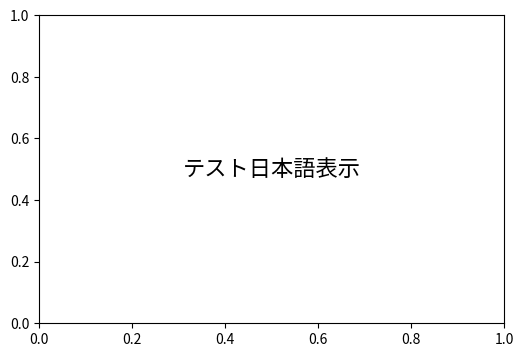

In [96]:
# 日本語フォントをインストール（既に完了）
# !apt-get -qq install fonts-noto-cjk

# matplotlibのフォントキャッシュをクリア（正しい方法）
import matplotlib.pyplot as plt
import matplotlib.font_manager
matplotlib.font_manager.fontManager.addfont('/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')

# 日本語フォントを設定
plt.rcParams['font.family'] = ['Noto Sans CJK JP', 'DejaVu Sans']

# テスト
plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, 'テスト日本語表示', ha='center', va='center', fontsize=16)
plt.show()

In [101]:
# === 学習データ評価 ===
def evaluate_sample_images(samples, model, transform, config, device,
                          title="画像評価", show_images=True):
    """
    サンプル画像を評価して結果を表示（パッチ1つ表示付き）

    Args:
        samples: 評価するサンプル
        model: 学習済みモデル
        transform: 前処理
        config: 設定オブジェクト
        device: デバイス
        title: 表示タイトル
        show_images: 画像表示有無

    Returns:
        tuple: (正解数, 総数, 精度)
    """
    print(f"\n=== {title} ===")

    selected_samples = select_diverse_samples(samples, 10, config.RANDOM_SEED)

    if show_images:
        # 4x5グリッド（10サンプル全部表示用）
        fig, axes = plt.subplots(4, 5, figsize=(20, 16))

    correct = 0
    results = []

    for i, (path, true_cls) in enumerate(selected_samples):
        # パッチベース予測 + サンプルパッチ取得
        pred_idx, pvec, patch_count, sample_patch = predict_image_with_sample_patch(
            path, model, transform,
            config.PATCH_SIZE, config.TEST_STRIDE,
            class_to_idx, device, "max"
        )

        if pred_idx is None:
            print(f"[{i+1:02d}] ❌ 処理失敗: {path}")
            continue

        pred_cls = idx_to_class[pred_idx]
        is_correct = (pred_cls == true_cls)
        correct += int(is_correct)

        # 上位3クラスの確率
        topk = sorted(enumerate(pvec), key=lambda x: x[1], reverse=True)[:3]
        topk_str = " / ".join([f"{idx_to_class[j]}: {prob*100:.1f}%" for j, prob in topk])

        result_line = (f"[{i+1:02d}] {'✅' if is_correct else '❌'} "
                      f"GT: {true_cls[:15]}{'...' if len(true_cls)>15 else ''} | "
                      f"PRED: {pred_cls[:15]}{'...' if len(pred_cls)>15 else ''} "
                      f"({patch_count}パッチ)")

        results.append(result_line)
        results.append(f"      確率: {topk_str}")
        results.append(f"      ファイル: {path.name}")
        results.append("")

        # 画像表示
        if show_images and i < 10:
            row = i // 5  # 行の計算（0,0,0,0,0,1,1,1,1,1）
            col = i % 5   # 列の計算（0,1,2,3,4,0,1,2,3,4）

            try:
                # 元画像
                img = Image.open(path).convert('RGB')
                axes[row*2, col].imshow(img)  # 偶数行（0,2行）に画像
                axes[row*2, col].axis('off')

                title_text = (f"[{i+1:02d}] {'✅' if is_correct else '❌'}\n"
                            f"GT: {true_cls[:10]}{'...' if len(true_cls)>10 else ''}\n"
                            f"PRED: {pred_cls[:10]}{'...' if len(pred_cls)>10 else ''}")
                axes[row*2, col].set_title(title_text, fontsize=9)

                # パッチ表示
                if sample_patch is not None:
                    axes[row*2+1, col].imshow(sample_patch)  # 奇数行（1,3行）にパッチ
                    axes[row*2+1, col].set_title(f"パッチ例\n64x64", fontsize=8)
                else:
                    axes[row*2+1, col].text(0.5, 0.5, "パッチ\n取得失敗", ha='center', va='center')
                axes[row*2+1, col].axis('off')

            except Exception as e:
                axes[row*2, col].text(0.5, 0.5, f"画像読み込み\nエラー",
                               ha='center', va='center', transform=axes[row*2, col].transAxes)
                axes[row*2, col].axis('off')
                axes[row*2+1, col].axis('off')

    # 未使用の軸を非表示
    if show_images:
        for i in range(len(selected_samples), 10):
            row = i // 5
            col = i % 5
            axes[row*2, col].axis('off')
            axes[row*2+1, col].axis('off')

        plt.suptitle(f"📊 {title} 結果（パッチ付き）", fontsize=16)
        plt.tight_layout()
        plt.show()

    # 結果サマリー
    accuracy = correct / len(selected_samples)
    print("\n".join(results))
    print(f"📊 {title}精度: {correct}/{len(selected_samples)} = {accuracy:.3f}")

    return correct, len(selected_samples), accuracy

🔍 学習データでの性能確認

=== 学習データ検証 ===


/tmp/ipython-input-173615874.py:99: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans, Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipython-input-173615874.py:99: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans, Noto Sans CJK JP.
  plt.tight_layout()
/tmp/ipython-input-173615874.py:99: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans, Noto Sans CJK JP.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans, Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)


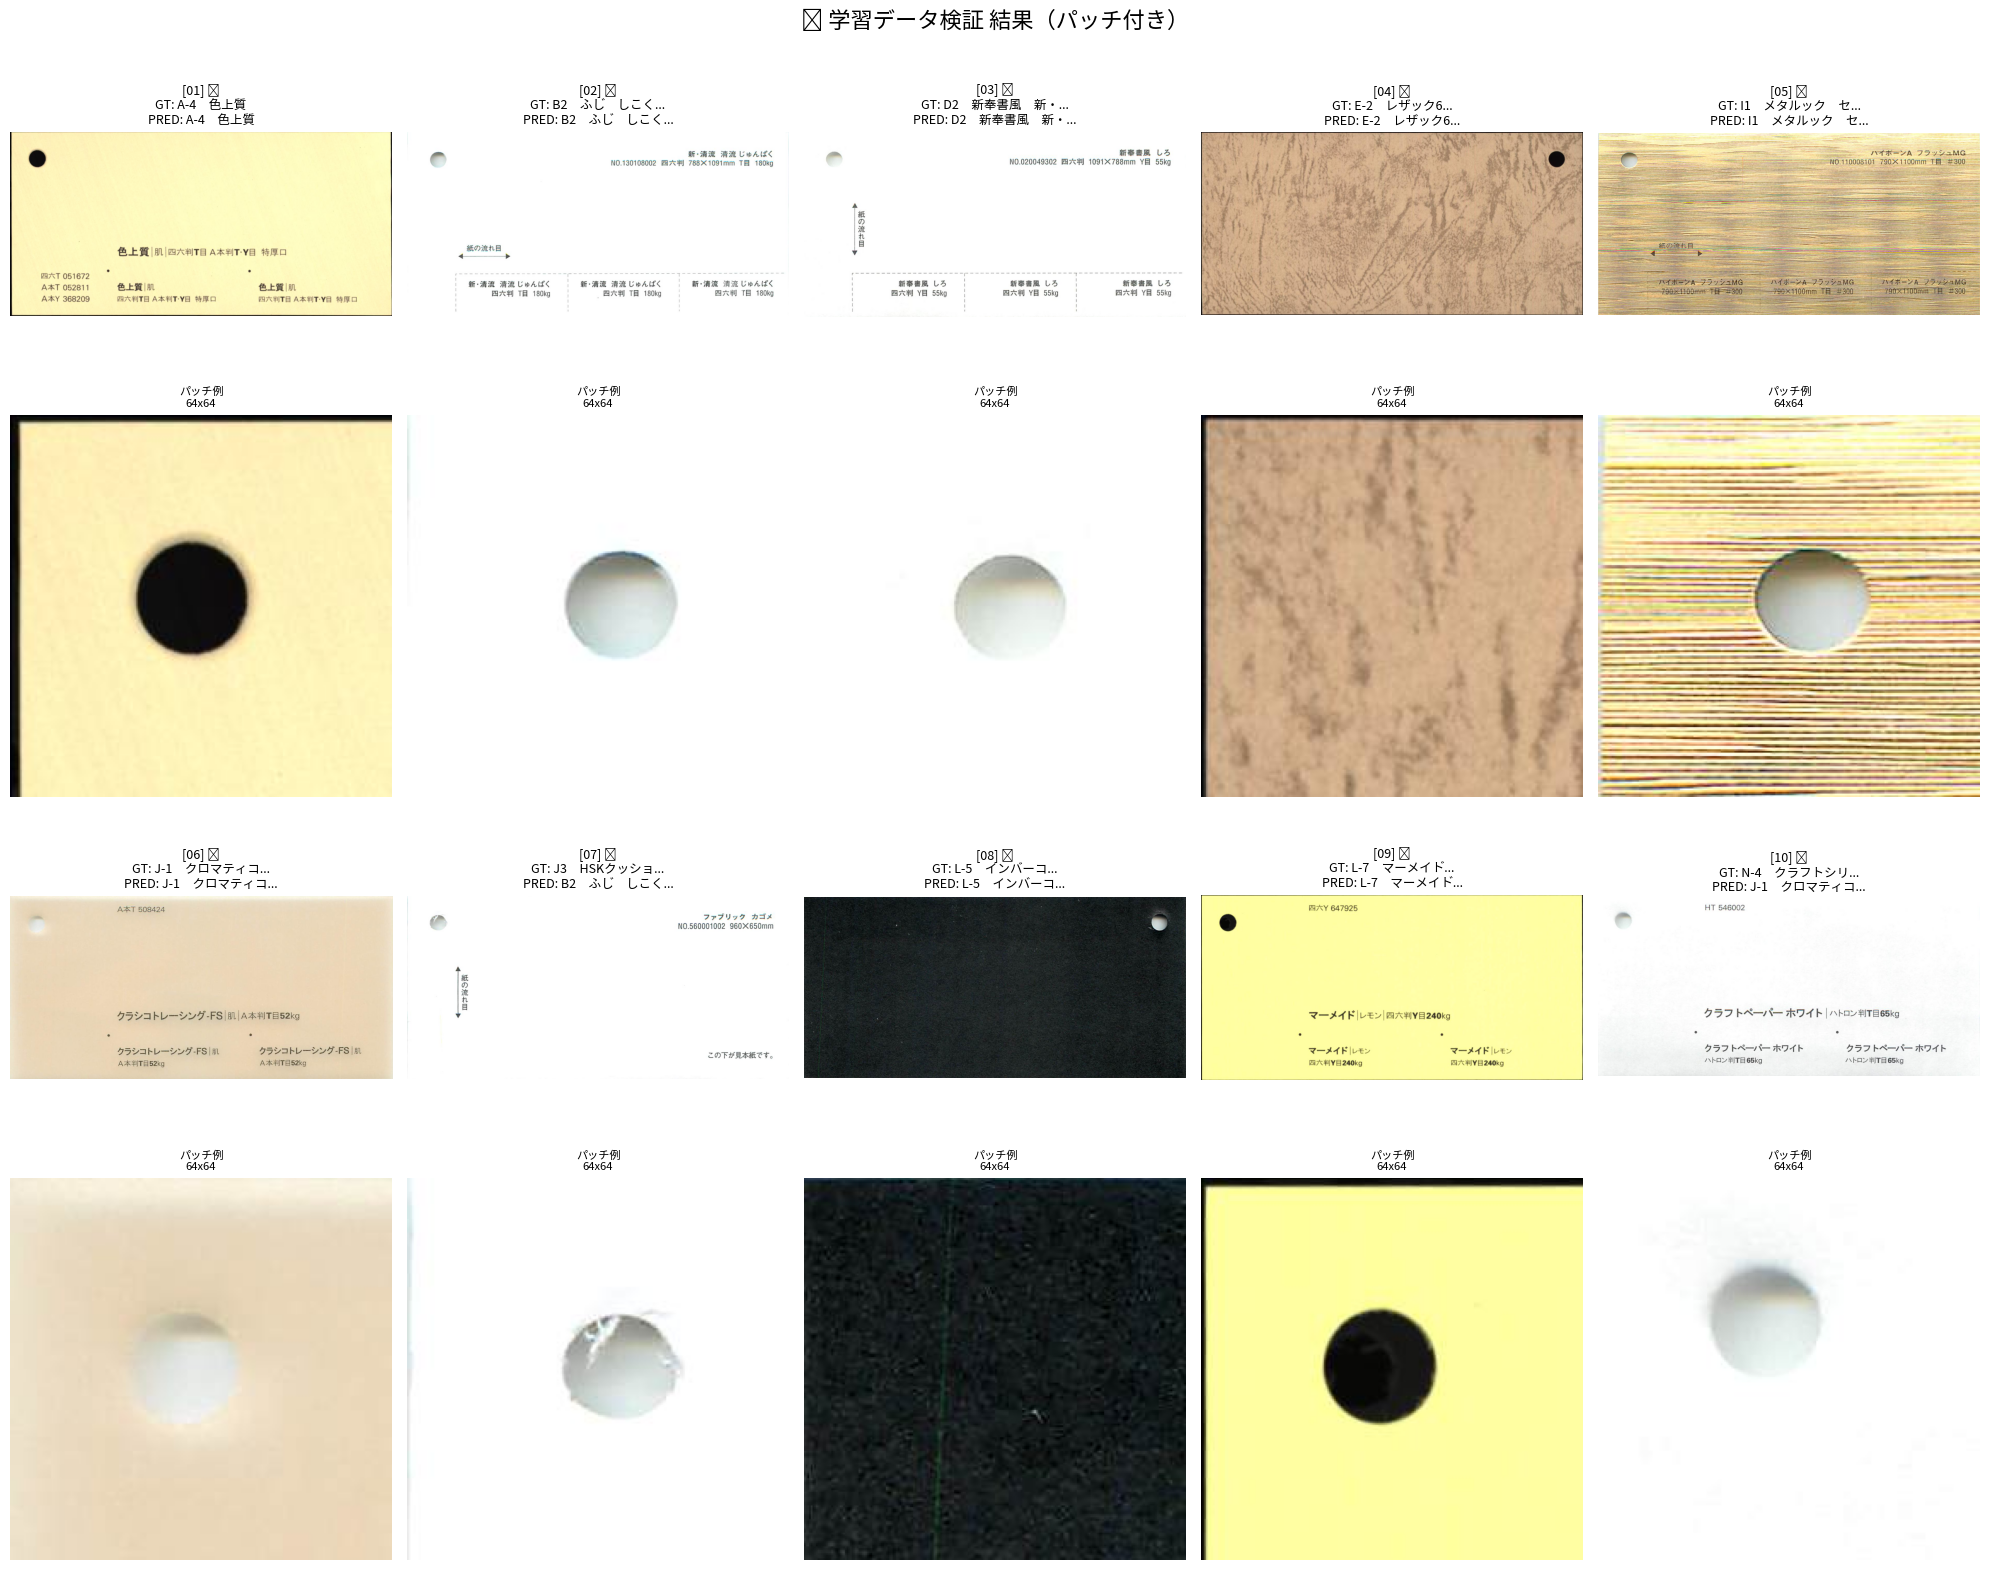

[01] ✅ GT: A-4　色上質 | PRED: A-4　色上質 (18パッチ)
      確率: A-4　色上質: 100.0% / L-7　マーメイド-LS: 6.8% / D2　新奉書風　新・北斎　ニューラグリンS　ビアンコネロF: 0.7%
      ファイル: 193.JPG

[02] ✅ GT: B2　ふじ　しこくてんれい　... | PRED: B2　ふじ　しこくてんれい　... (18パッチ)
      確率: B2　ふじ　しこくてんれい　新・清流　MLファイバー　小豆殻CoC　新・星物語　アトモス　新アトモス　新利休　フラスコ: 87.5% / D2　新奉書風　新・北斎　ニューラグリンS　ビアンコネロF: 71.9% / L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード: 25.6%
      ファイル: 057.jpg

[03] ✅ GT: D2　新奉書風　新・北斎　ニュ... | PRED: D2　新奉書風　新・北斎　ニュ... (18パッチ)
      確率: D2　新奉書風　新・北斎　ニューラグリンS　ビアンコネロF: 92.1% / B2　ふじ　しこくてんれい　新・清流　MLファイバー　小豆殻CoC　新・星物語　アトモス　新アトモス　新利休　フラスコ: 75.2% / L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード: 25.6%
      ファイル: 013.jpg

[04] ✅ GT: E-2　レザック66 | PRED: E-2　レザック66 (18パッチ)
      確率: E-2　レザック66: 99.9% / J-1　クロマティコA-FS　NTパイル　XDTトレーシング-FS　クラシコグロス　クラシコトレーシング-FS　クラシコトレーシング-FS風・星くずし　ドリープ・W　ドリープF　アートドリープ: 28.3% / L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード: 1.9%

In [102]:
# === 学習データ評価実行 ===
print("🔍 学習データでの性能確認")
train_correct, train_total, train_acc = evaluate_sample_images(
    train_samples,  # 最初に作成したtrain_samples変数を使用
    model, test_tf, config, device,
    title="学習データ検証", show_images=True
)

🎯 テストデータでの最終評価

=== テストデータ評価 ===


/tmp/ipython-input-3089688802.py:93: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3089688802.py:93: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3089688802.py:93: UserWarning: Glyph 33394 (\N{CJK UNIFIED IDEOGRAPH-8272}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3089688802.py:93: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3089688802.py:93: UserWarning: Glyph 36074 (\N{CJK UNIFIED IDEOGRAPH-8CEA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3089688802.py:93: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3089688802.py:93: UserWarning: Glyph 12405 (\N{HIRAGANA LETTER HU}) missing from font(s) DejaVu Sans.
  plt.tig

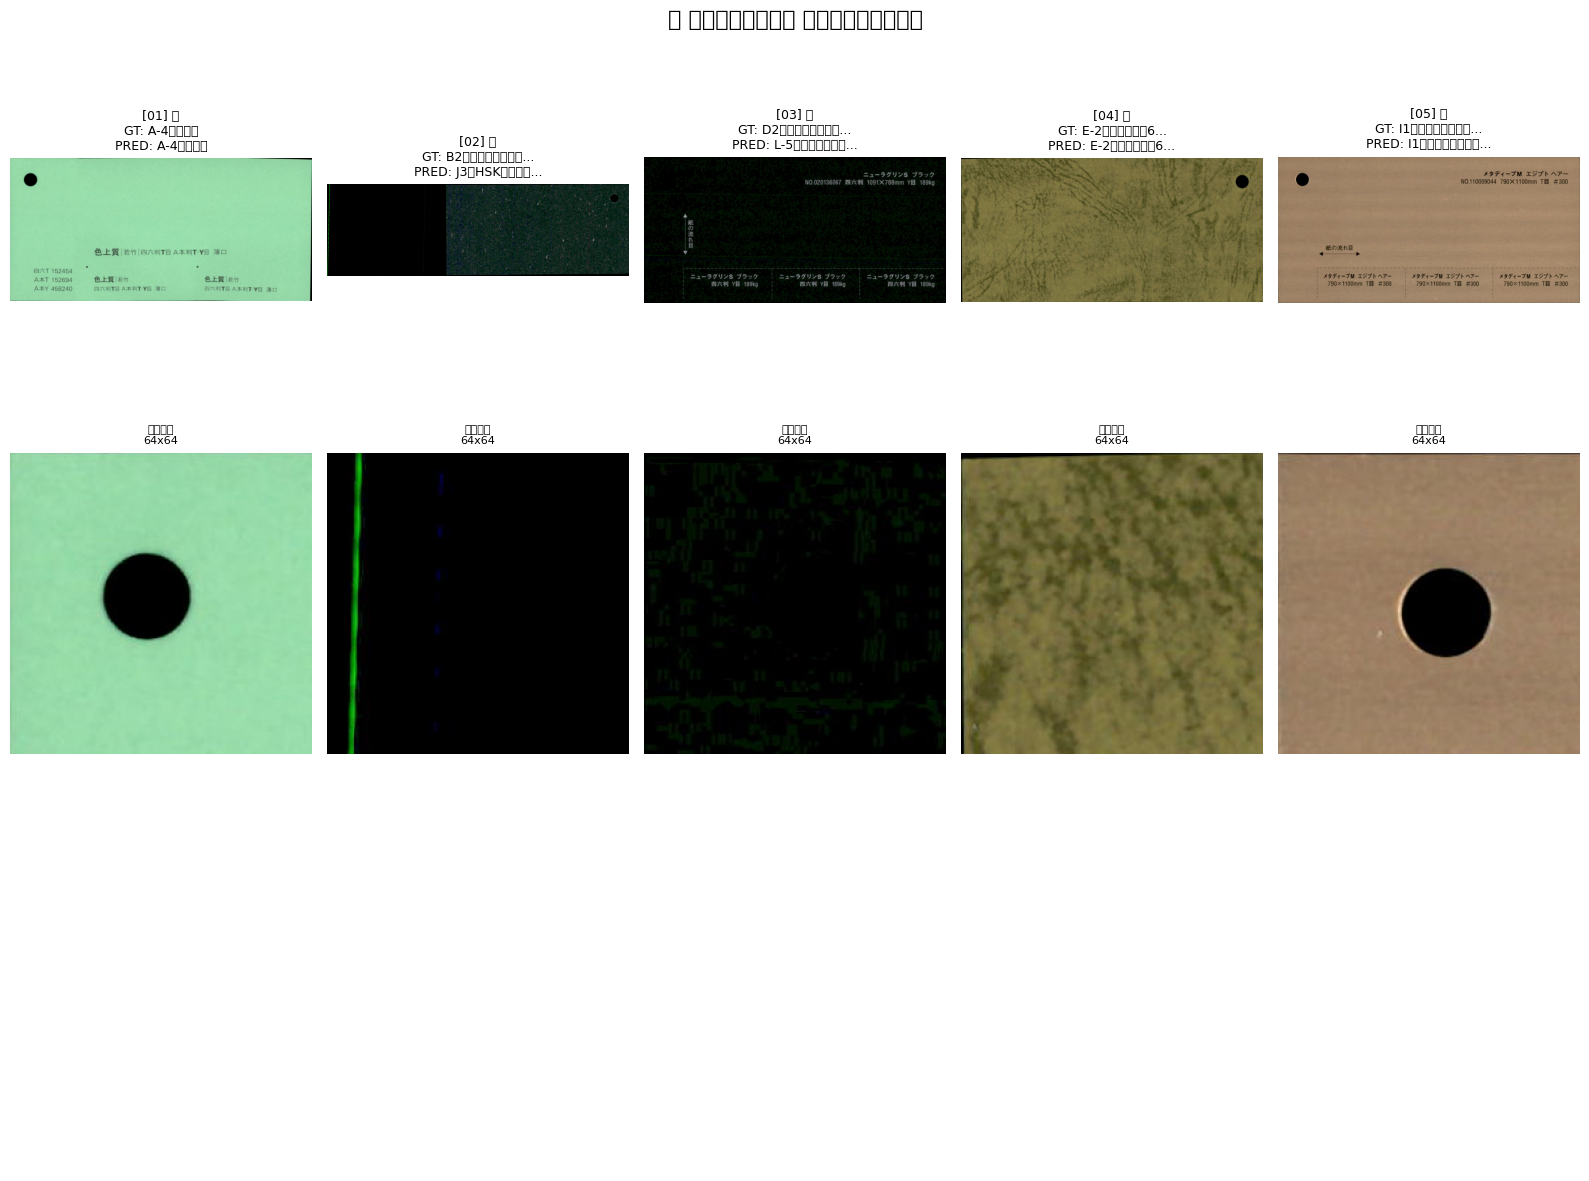

[01] ✅ GT: A-4　色上質 | PRED: A-4　色上質 (18パッチ)
      確率: A-4　色上質: 99.8% / L-7　マーメイド-LS: 68.6% / J-1　クロマティコA-FS　NTパイル　XDTトレーシング-FS　クラシコグロス　クラシコトレーシング-FS　クラシコトレーシング-FS風・星くずし　ドリープ・W　ドリープF　アートドリープ: 2.4%
      ファイル: 439.jpg

[02] ❌ GT: B2　ふじ　しこくてんれい　... | PRED: J3　HSKクッションF　特A... (33パッチ)
      確率: J3　HSKクッションF　特Aクッション　SSコースター　ニューウエブロンカラー　ファブリック　コルクシートN: 99.4% / L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード: 51.2% / E-2　レザック66: 37.8%
      ファイル: 140.jpg

[03] ❌ GT: D2　新奉書風　新・北斎　ニュ... | PRED: L-5　インバーコート　気泡... (18パッチ)
      確率: L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード: 87.8% / J3　HSKクッションF　特Aクッション　SSコースター　ニューウエブロンカラー　ファブリック　コルクシートN: 87.0% / D2　新奉書風　新・北斎　ニューラグリンS　ビアンコネロF: 5.3%
      ファイル: 125.jpg

[04] ✅ GT: E-2　レザック66 | PRED: E-2　レザック66 (18パッチ)
      確率: E-2　レザック66: 99.9% / B2　ふじ　しこくてんれい　新・清流　MLファイバー　小豆殻CoC　新・星物語　アトモス　新アトモス　新利休　フラスコ: 0.9% / J3　HSKクッションF　特Aクッション　SSコースター　ニューウエブロンカラー　ファブリック　コルクシートN: 0.7%
      ファイル: 

In [86]:
# === テストデータ評価実行 ===
print("🎯 テストデータでの最終評価")
test_correct, test_total, test_acc = evaluate_sample_images(
    test_samples, model, test_tf, config, device,
    title="テストデータ評価", show_images=True
)

In [104]:
# === パフォーマンス詳細分析 ===
def analyze_class_performance(samples, model, transform, config, device, top_n=10):
    """
    クラス別性能分析

    Args:
        samples: 評価サンプル
        model: モデル
        transform: 前処理
        config: 設定
        device: デバイス
        top_n: 表示する上位クラス数

    Returns:
        dict: クラス別統計
    """
    print("\n=== 📊 クラス別性能分析 ===")

    # クラス別サンプル数カウント
    class_counts = defaultdict(int)
    for _, cls in samples:
        class_counts[cls] += 1

    # 上位クラスを選択
    top_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    class_results = {}

    for cls_name, count in top_classes:
        print(f"\n🔍 クラス: {cls_name} ({count}枚)")

        # 該当クラスのサンプルを選択
        cls_samples = [(p, c) for p, c in samples if c == cls_name]
        selected = select_diverse_samples(cls_samples, min(3, len(cls_samples)), config.RANDOM_SEED)

        correct = 0
        predictions = []

        for path, true_cls in selected:
            pred_idx, pvec, patch_count = predict_image_with_patches(
                path, model, transform,
                config.PATCH_SIZE, config.TEST_STRIDE,
                class_to_idx, device, "max"
            )

            if pred_idx is not None:
                pred_cls = idx_to_class[pred_idx]
                is_correct = (pred_cls == true_cls)
                correct += int(is_correct)

                confidence = pvec[pred_idx] * 100
                predictions.append({
                    'file': path.name,
                    'correct': is_correct,
                    'predicted': pred_cls,
                    'confidence': confidence,
                    'patches': patch_count
                })

        accuracy = correct / len(selected) if selected else 0
        avg_confidence = sum(p['confidence'] for p in predictions) / len(predictions) if predictions else 0

        class_results[cls_name] = {
            'accuracy': accuracy,
            'confidence': avg_confidence,
            'sample_count': count,
            'predictions': predictions
        }

        print(f"   ✅ 精度: {accuracy:.3f} ({correct}/{len(selected)})")
        print(f"   🎯 平均確信度: {avg_confidence:.1f}%")

        # 詳細結果
        for pred in predictions:
            status = "✅" if pred['correct'] else "❌"
            print(f"     {status} {pred['file'][:30]} | 確信度: {pred['confidence']:.1f}% | {pred['patches']}パッチ")

    return class_results

# クラス別分析実行
class_perf = analyze_class_performance(test_samples, model, test_tf, config, device)



=== 📊 クラス別性能分析 ===

🔍 クラス: E-2　レザック66 (502枚)
   ✅ 精度: 1.000 (3/3)
   🎯 平均確信度: 100.0%
     ✅ 445.jpg | 確信度: 100.0% | 18パッチ
     ✅ 180.jpg | 確信度: 99.9% | 18パッチ
     ✅ 132.jpg | 確信度: 99.9% | 18パッチ

🔍 クラス: A-4　色上質 (464枚)
   ✅ 精度: 1.000 (3/3)
   🎯 平均確信度: 98.1%
     ✅ 439.jpg | 確信度: 99.8% | 18パッチ
     ✅ 165.jpg | 確信度: 99.9% | 18パッチ
     ✅ 124.jpg | 確信度: 94.4% | 18パッチ

🔍 クラス: B2　ふじ　しこくてんれい　新・清流　MLファイバー　小豆殻CoC　新・星物語　アトモス　新アトモス　新利休　フラスコ (254枚)
   ✅ 精度: 0.667 (2/3)
   🎯 平均確信度: 96.0%
     ✅ 019.jpg | 確信度: 99.4% | 18パッチ
     ❌ 140.jpg | 確信度: 99.4% | 33パッチ
     ✅ 114.jpg | 確信度: 89.3% | 18パッチ

🔍 クラス: J-1　クロマティコA-FS　NTパイル　XDTトレーシング-FS　クラシコグロス　クラシコトレーシング-FS　クラシコトレーシング-FS風・星くずし　ドリープ・W　ドリープF　アートドリープ (188枚)
   ✅ 精度: 1.000 (3/3)
   🎯 平均確信度: 88.4%
     ✅ 090.jpg | 確信度: 66.6% | 18パッチ
     ✅ 143.jpg | 確信度: 99.0% | 18パッチ
     ✅ 120.jpg | 確信度: 99.7% | 18パッチ

🔍 クラス: N-4　クラフトシリーズ (186枚)
   ✅ 精度: 0.333 (1/3)
   🎯 平均確信度: 92.0%
     ❌ 083.jpg | 確信度: 96.9% | 18パッチ
     ✅ 138.jpg | 確信度: 90.9% | 18パッチ

In [88]:
# === 最終結果サマリー ===
def print_final_summary(train_acc, test_acc, class_perf, config):
    """最終結果をサマリー表示"""
    print("\n" + "="*60)
    print("🎉 最終評価結果サマリー")
    print("="*60)

    print(f"📊 モデル設定:")
    print(f"   - アーキテクチャ: ResNet18")
    print(f"   - パッチサイズ: {config.PATCH_SIZE}x{config.PATCH_SIZE}")
    print(f"   - 学習ストライド: {config.TRAIN_STRIDE}")
    print(f"   - テストストライド: {config.TEST_STRIDE}")
    print(f"   - バッチサイズ: {config.BATCH_SIZE}")
    print(f"   - エポック数: {config.NUM_EPOCHS}")

    print(f"\n📈 性能結果:")
    print(f"   - 学習データ精度: {train_acc:.3f}")
    print(f"   - テストデータ精度: {test_acc:.3f}")

    if class_perf:
        avg_class_acc = sum(info['accuracy'] for info in class_perf.values()) / len(class_perf)
        avg_confidence = sum(info['confidence'] for info in class_perf.values()) / len(class_perf)
        print(f"   - 平均クラス精度: {avg_class_acc:.3f}")
        print(f"   - 平均確信度: {avg_confidence:.1f}%")

    print(f"\n💾 保存ファイル:")
    print(f"   - train_index.pt: 学習用インデックス")
    print(f"   - test_index.pt: テスト用インデックス")

    print("\n🔧 改善提案:")
    if test_acc < 0.7:
        print("   - データ拡張の追加を検討")
        print("   - より大きなモデル(ResNet50等)の使用")
        print("   - 学習エポック数の増加")
    elif test_acc > 0.9:
        print("   - モデルの軽量化が可能かもしれません")
        print("   - より困難なテストケースの追加を検討")
    else:
        print("   - パラメータチューニングで更なる改善が期待できます")
        print("   - クラス不均衡の対策を検討")

    print("="*60)

print_final_summary(train_acc, test_acc, class_perf, config)


🎉 最終評価結果サマリー
📊 モデル設定:
   - アーキテクチャ: ResNet18
   - パッチサイズ: 224x224
   - 学習ストライド: 224
   - テストストライド: 224
   - バッチサイズ: 128
   - エポック数: 3

📈 性能結果:
   - 学習データ精度: 0.800
   - テストデータ精度: 0.600
   - 平均クラス精度: 0.800
   - 平均確信度: 94.9%

💾 保存ファイル:
   - train_index.pt: 学習用インデックス
   - test_index.pt: テスト用インデックス

🔧 改善提案:
   - データ拡張の追加を検討
   - より大きなモデル(ResNet50等)の使用
   - 学習エポック数の増加


In [89]:
# === モデル保存 ===
def save_model_and_config(model, config, class_to_idx, save_dir="./saved_model"):
    """
    モデルと設定を保存

    Args:
        model: 学習済みモデル
        config: 設定オブジェクト
        class_to_idx: クラス辞書
        save_dir: 保存ディレクトリ
    """
    save_path = Path(save_dir)
    save_path.mkdir(exist_ok=True)

    # モデル保存
    model_path = save_path / "model.pt"
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_class': 'ResNet18',
        'num_classes': len(class_to_idx),
    }, model_path)

    # 設定・クラス情報保存
    config_path = save_path / "config.json"
    config_data = {
        'patch_size': config.PATCH_SIZE,
        'train_stride': config.TRAIN_STRIDE,
        'test_stride': config.TEST_STRIDE,
        'batch_size': config.BATCH_SIZE,
        'num_epochs': config.NUM_EPOCHS,
        'learning_rate': config.LEARNING_RATE,
        'class_to_idx': class_to_idx,
        'idx_to_class': {str(k): v for k, v in idx_to_class.items()},
        'num_classes': len(class_to_idx)
    }

    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(config_data, f, indent=2, ensure_ascii=False)

    print(f"💾 モデル保存完了: {model_path}")
    print(f"💾 設定保存完了: {config_path}")

# モデル保存実行
save_model_and_config(model, config, class_to_idx)

💾 モデル保存完了: saved_model/model.pt
💾 設定保存完了: saved_model/config.json


# 6. 推論用ユーティリティ


In [90]:
# === 推論用クラス ===
class PaperClassifier:
    """
    推論専用クラス

    Features:
    - 保存済みモデルのロード
    - 単一画像の分類
    - バッチ推論対応
    """

    def __init__(self, model_path, config_path, device=None):
        """
        Args:
            model_path: モデルファイルパス
            config_path: 設定ファイルパス
            device: 推論デバイス
        """
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # 設定読み込み
        with open(config_path, 'r', encoding='utf-8') as f:
            self.config = json.load(f)

        # クラス情報
        self.class_to_idx = self.config['class_to_idx']
        self.idx_to_class = {int(k): v for k, v in self.config['idx_to_class'].items()}
        self.num_classes = self.config['num_classes']

        # モデル構築・ロード
        self.model = create_model(self.num_classes, pretrained=False)
        checkpoint = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()

        # 前処理
        _, self.transform = get_transforms()

        print(f"🤖 分類器初期化完了")
        print(f"   - クラス数: {self.num_classes}")
        print(f"   - デバイス: {self.device}")

    def predict_single(self, image_path, aggregation="max", return_confidence=True):
        """
        単一画像の分類

        Args:
            image_path: 画像パス
            aggregation: パッチ集約方法
            return_confidence: 確信度返却有無

        Returns:
            dict: 予測結果
        """
        pred_idx, pvec, patch_count = predict_image_with_patches(
            image_path, self.model, self.transform,
            self.config['patch_size'], self.config['test_stride'],
            self.class_to_idx, self.device, aggregation
        )

        if pred_idx is None:
            return {'error': 'Failed to process image'}

        result = {
            'predicted_class': self.idx_to_class[pred_idx],
            'predicted_index': pred_idx,
            'patch_count': patch_count
        }

        if return_confidence:
            result['confidence'] = float(pvec[pred_idx])
            # 上位3クラス
            topk = sorted(enumerate(pvec), key=lambda x: x[1], reverse=True)[:3]
            result['top_predictions'] = [
                {
                    'class': self.idx_to_class[idx],
                    'confidence': float(conf)
                }
                for idx, conf in topk
            ]

        return result

    def predict_batch(self, image_paths, aggregation="max"):
        """
        バッチ推論

        Args:
            image_paths: 画像パスのリスト
            aggregation: パッチ集約方法

        Returns:
            list: 予測結果のリスト
        """
        results = []
        for path in tqdm(image_paths, desc="🔮 バッチ推論"):
            result = self.predict_single(path, aggregation)
            result['image_path'] = str(path)
            results.append(result)
        return results

In [91]:
# === 推論デモ ===
def demo_inference():
    """推論デモ実行"""
    print("\n=== 🔮 推論デモ ===")

    # 分類器初期化
    classifier = PaperClassifier("./saved_model/model.pt", "./saved_model/config.json")

    # テストサンプルで推論テスト
    demo_samples = select_diverse_samples(test_samples, 3, config.RANDOM_SEED)

    print("📋 推論結果:")
    for i, (path, true_cls) in enumerate(demo_samples, 1):
        result = classifier.predict_single(path)

        if 'error' in result:
            print(f"[{i}] ❌ エラー: {result['error']}")
            continue

        is_correct = result['predicted_class'] == true_cls
        status = "✅" if is_correct else "❌"

        print(f"\n[{i}] {status} 画像: {path.name}")
        print(f"    正解: {true_cls}")
        print(f"    予測: {result['predicted_class']}")
        print(f"    確信度: {result['confidence']:.3f}")
        print(f"    パッチ数: {result['patch_count']}")

        print("    上位3予測:")
        for j, pred in enumerate(result['top_predictions'], 1):
            print(f"      {j}. {pred['class']}: {pred['confidence']:.3f}")

# 推論デモ実行
demo_inference()



=== 🔮 推論デモ ===
🤖 分類器初期化完了
   - クラス数: 10
   - デバイス: cuda
📋 推論結果:

[1] ✅ 画像: 439.jpg
    正解: A-4　色上質
    予測: A-4　色上質
    確信度: 0.998
    パッチ数: 18
    上位3予測:
      1. A-4　色上質: 0.998
      2. L-7　マーメイド-LS: 0.686
      3. J-1　クロマティコA-FS　NTパイル　XDTトレーシング-FS　クラシコグロス　クラシコトレーシング-FS　クラシコトレーシング-FS風・星くずし　ドリープ・W　ドリープF　アートドリープ: 0.024

[2] ❌ 画像: 140.jpg
    正解: B2　ふじ　しこくてんれい　新・清流　MLファイバー　小豆殻CoC　新・星物語　アトモス　新アトモス　新利休　フラスコ
    予測: J3　HSKクッションF　特Aクッション　SSコースター　ニューウエブロンカラー　ファブリック　コルクシートN
    確信度: 0.994
    パッチ数: 33
    上位3予測:
      1. J3　HSKクッションF　特Aクッション　SSコースター　ニューウエブロンカラー　ファブリック　コルクシートN: 0.994
      2. L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード: 0.512
      3. E-2　レザック66: 0.378

[3] ❌ 画像: 125.jpg
    正解: D2　新奉書風　新・北斎　ニューラグリンS　ビアンコネロF
    予測: L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード
    確信度: 0.878
    パッチ数: 18
    上位3予測:
      1. L-5　インバーコート　気泡紙　黒気泡紙　シンボルパック-FS　スノーブル-FS　テイクGAボード-FS　GAクラフトボード: 0.878
      2. J3　HSKクッショ